In [ ]:
!pip install datasist

In [ ]:
!pip install catboost==0.24.1

In [ ]:
import pandas as pd
import numpy as np
import datasist as ds
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
train = pd.read_csv("/content/drive/My Drive/Train (61).csv")
test = pd.read_csv("/content/drive/My Drive/Test (43).csv")
sub = pd.read_csv("/content/drive/My Drive/SampleSubmission (36).csv")

In [ ]:
train.shape, test.shape, sub.shape

((56000, 52), (24000, 51), (24000, 2))

In [ ]:
train.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,4397256.0,2301324.0,7875694.0,96375139,112181765.0,1.0,1.0,1.0,3.0,3.0,134.655,NaN,NaN,134.655,4000.5,17064.0,11376.0,60.0,17064.0,5962.0,NaN,1052.0,8.0000,2.0,NaN,12.0,12.0,4.0,0.0,NaN,NaN,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,no
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,244292.0,3982971.0,2141445.0,28141427,45169902.0,1.0,1.0,1.0,2.0,2.0,109.230,11385.24,14584.29,86.685,4161.0,13413.0,8942.0,304.0,13413.0,5780.0,NaN,2554.0,17.5000,0.0,0.0,16.0,24.0,8.0,0.0,NaN,NaN,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,no
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,NaN,0.0,16576457,22452691.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,NaN,14508.0,70.0,0.6666,0.0,NaN,12.0,0.0,6.0,0.0,149.6805,NaN,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,yes
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,NaN,771776.0,1186839.0,48187375,136297820.0,0.0,0.0,0.0,1.0,1.0,120.120,8580.00,0.00,85.800,1701.0,4014.0,2676.0,60.0,11679.0,NaN,NaN,522.0,7.8334,1.0,1.0,4.0,8.0,4.0,1.0,NaN,NaN,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,no
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,396391.0,818456.0,511535.0,28141427,15292757.0,0.0,0.0,0.0,3.0,3.0,104.535,8360.19,10326.45,115.335,1551.0,3285.0,2190.0,60.0,19437.0,12958.0,5202.0,272.0,1.0000,0.0,0.0,24.0,2.0,24.0,0.0,150.0135,NaN,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,no


In [ ]:
test.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50
0,Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,1649749.0,5446.0,0.0,48187375,114686147.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1086.0,6204.0,2676.0,60.0,14691.0,9794.0,NaN,238.0,1.8334,0.0,NaN,22.0,2.0,14.0,0.0,NaN,NaN,0.825000,1.01,0.800000,NaN,0.0,charge,NaN,0.000000,0.011221
1,Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,622789.0,1025793.0,1396510.0,34694910,87479487.0,1.0,1.0,1.0,2.0,2.0,142.560,NaN,NaN,570.585,3082.5,10221.0,6814.0,60.0,11955.0,3528.0,NaN,1216.0,19.5000,3.0,NaN,30.0,18.0,14.0,2.0,NaN,18.8415,0.507694,4.04,0.623248,1.0,0.0,lending,NaN,0.504974,0.043525
2,Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,0.0,118256.0,NaN,NaN,21973443,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,852.0,4836.0,NaN,NaN,NaN,7.8334,0.0,NaN,2.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,charge,NaN,0.000000,NaN
3,Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,493641.0,1391064.0,1176725.0,1220293.0,16576457,NaN,2.0,2.0,2.0,3.0,3.0,109.005,13050.00,NaN,109.005,1414.5,4197.0,2798.0,60.0,14964.0,NaN,NaN,248.0,9.0000,1.0,1.0,36.0,0.0,26.0,0.0,NaN,NaN,0.916663,2.02,0.464224,NaN,NaN,charge,90.163742,0.788809,0.104029
4,Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,5752921.0,271133.0,613064.0,4779643.0,48187375,72049802.0,0.0,0.0,0.0,3.0,3.0,139.065,469.29,469.29,15.180,2724.0,9855.0,6570.0,182.0,11679.0,5900.0,NaN,2388.0,16.6666,1.0,0.0,24.0,28.0,20.0,0.0,NaN,NaN,0.234047,23.23,0.726688,0.0,0.0,lending,1303.587148,1.637733,0.163124


In [ ]:
sub.head()

,Applicant_ID,default_status
0,Apcnt_1000032,1
1,Apcnt_1000048,1
2,Apcnt_1000052,1
3,Apcnt_1000076,1
4,Apcnt_1000080,1


In [ ]:
train['default_status'].value_counts()

no     42285
yes    13715
Name: default_status, dtype: int64

In [ ]:
train.isnull().sum()

Applicant_ID          0
form_field1        2529
form_field2        3844
form_field3         355
form_field4         355
form_field5         355
form_field6       13360
form_field7        5163
form_field8       13360
form_field9        8008
form_field10        355
form_field11      31421
form_field12       9895
form_field13       5889
form_field14          0
form_field15      22475
form_field16      13036
form_field17      11151
form_field18      10402
form_field19          4
form_field20        355
form_field21      15854
form_field22      20400
form_field23      28123
form_field24      13297
form_field25       5450
form_field26       7438
form_field27       9299
form_field28        355
form_field29        355
form_field30      25509
form_field31      39408
form_field32       5450
form_field33       1256
form_field34        355
form_field35      23148
form_field36       1995
form_field37       5450
form_field38        355
form_field39       4211
form_field40      43729
form_field41    

In [ ]:
test.isnull().sum()

Applicant_ID        0
form_field1      1110
form_field2      1709
form_field3       146
form_field4       146
form_field5       146
form_field6      5604
form_field7      2231
form_field8      5604
form_field9      3400
form_field10      147
form_field11    13398
form_field12     4183
form_field13     2463
form_field14        0
form_field15     9592
form_field16     5474
form_field17     4695
form_field18     4369
form_field19        0
form_field20      147
form_field21     6707
form_field22     8724
form_field23    12125
form_field24     5605
form_field25     2256
form_field26     3172
form_field27     3910
form_field28      147
form_field29      147
form_field30    10908
form_field31    16810
form_field32     2256
form_field33      495
form_field34      147
form_field35     9866
form_field36      903
form_field37     2256
form_field38      147
form_field39     1829
form_field40    18828
form_field41    16349
form_field42      578
form_field43      250
form_field44     2362
form_field

In [ ]:
categorical_features=[feature for feature in train.columns if train[feature].dtype=='O'];categorical_features

['Applicant_ID', 'form_field47', 'default_status']

In [ ]:
numerical_features=[feature for feature in train.columns if train[feature].dtype!='O'];numerical_features

['form_field1',
 'form_field2',
 'form_field3',
 'form_field4',
 'form_field5',
 'form_field6',
 'form_field7',
 'form_field8',
 'form_field9',
 'form_field10',
 'form_field11',
 'form_field12',
 'form_field13',
 'form_field14',
 'form_field15',
 'form_field16',
 'form_field17',
 'form_field18',
 'form_field19',
 'form_field20',
 'form_field21',
 'form_field22',
 'form_field23',
 'form_field24',
 'form_field25',
 'form_field26',
 'form_field27',
 'form_field28',
 'form_field29',
 'form_field30',
 'form_field31',
 'form_field32',
 'form_field33',
 'form_field34',
 'form_field35',
 'form_field36',
 'form_field37',
 'form_field38',
 'form_field39',
 'form_field40',
 'form_field41',
 'form_field42',
 'form_field43',
 'form_field44',
 'form_field45',
 'form_field46',
 'form_field48',
 'form_field49',
 'form_field50']

In [ ]:
ds.structdata.display_missing(train)

,features,missing_counts,missing_percent
0,Applicant_ID,0,0.0
1,form_field1,2529,4.5
2,form_field2,3844,6.9
3,form_field3,355,0.6
4,form_field4,355,0.6
5,form_field5,355,0.6
6,form_field6,13360,23.9
7,form_field7,5163,9.2
8,form_field8,13360,23.9
9,form_field9,8008,14.3


In [ ]:
ds.structdata.display_missing(test)

,features,missing_counts,missing_percent
0,Applicant_ID,0,0.0
1,form_field1,1110,4.6
2,form_field2,1709,7.1
3,form_field3,146,0.6
4,form_field4,146,0.6
5,form_field5,146,0.6
6,form_field6,5604,23.4
7,form_field7,2231,9.3
8,form_field8,5604,23.4
9,form_field9,3400,14.2


#Remove columns with more than 50% missing values from train dataset(data):


In [ ]:
def show_null_columns(data,agg,threshold):
    if agg=='sum':
       null_cols=data.isnull().sum()
    elif agg=='mean':
       null_cols=data.isnull().mean()
    columns=data.columns
    null_dic={}
    for col,x in zip(columns,null_cols):
        if x>=threshold:
            null_dic[col]=x
    return null_dic
null_dic=show_null_columns(train,'mean',0.3)  #0.5
train2=train.drop(null_dic.keys(),axis=1)
train2.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field12,form_field13,form_field14,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field32,form_field33,form_field34,form_field36,form_field37,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field47,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,2301324.0,7875694.0,96375139,1.0,1.0,1.0,3.0,3.0,134.655,134.655,4000.5,17064.0,11376.0,60.0,17064.0,1052.0,8.0000,2.0,12.0,12.0,4.0,0.0,0.392854,2.02,0.711632,0.0,charge,1.129518,0.044335,no
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,3982971.0,2141445.0,28141427,1.0,1.0,1.0,2.0,2.0,109.230,86.685,4161.0,13413.0,8942.0,304.0,13413.0,2554.0,17.5000,0.0,16.0,24.0,8.0,0.0,0.314281,8.08,0.183584,0.0,charge,1.620483,0.322436,no
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,0.0,16576457,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,70.0,0.6666,0.0,12.0,0.0,6.0,0.0,0.162965,18.18,0.791136,0.0,charge,1.513370,0.011640,yes
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,771776.0,1186839.0,48187375,0.0,0.0,0.0,1.0,1.0,120.120,85.800,1701.0,4014.0,2676.0,60.0,11679.0,522.0,7.8334,1.0,4.0,8.0,4.0,1.0,0.488884,2.02,0.685168,0.0,charge,0.664452,0.082729,no
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,818456.0,511535.0,28141427,0.0,0.0,0.0,3.0,3.0,104.535,115.335,1551.0,3285.0,2190.0,60.0,19437.0,272.0,1.0000,0.0,24.0,2.0,24.0,0.0,0.275000,12.12,0.438168,0.0,charge,1.427891,0.045630,no


#Remove columns with more than 50% missing values from test dataset(test2):

In [ ]:
def show_null_columns(data,agg,threshold):
    if agg=='sum':
       null_cols=data.isnull().sum()
    elif agg=='mean':
       null_cols=data.isnull().mean()
    columns=data.columns
    null_dic={}
    for col,x in zip(columns,null_cols):
        if x>=threshold:
            null_dic[col]=x
    return null_dic
null_dic=show_null_columns(train,'mean',0.3)   #0.5
test2=test.drop(null_dic.keys(),axis=1)
test2.head()

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field12,form_field13,form_field14,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field32,form_field33,form_field34,form_field36,form_field37,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field47,form_field49,form_field50
0,Apcnt_1000032,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,5446.0,0.0,48187375,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1086.0,6204.0,2676.0,60.0,14691.0,238.0,1.8334,0.0,22.0,2.0,14.0,0.0,0.825000,1.01,0.800000,0.0,charge,0.000000,0.011221
1,Apcnt_1000048,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,1025793.0,1396510.0,34694910,1.0,1.0,1.0,2.0,2.0,142.560,570.585,3082.5,10221.0,6814.0,60.0,11955.0,1216.0,19.5000,3.0,30.0,18.0,14.0,2.0,0.507694,4.04,0.623248,0.0,lending,0.504974,0.043525
2,Apcnt_1000052,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,21973443,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,852.0,4836.0,NaN,7.8334,0.0,2.0,NaN,0.0,NaN,NaN,0.00,NaN,NaN,charge,0.000000,NaN
3,Apcnt_1000076,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,493641.0,1176725.0,1220293.0,16576457,2.0,2.0,2.0,3.0,3.0,109.005,109.005,1414.5,4197.0,2798.0,60.0,14964.0,248.0,9.0000,1.0,36.0,0.0,26.0,0.0,0.916663,2.02,0.464224,NaN,charge,0.788809,0.104029
4,Apcnt_1000080,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,5752921.0,613064.0,4779643.0,48187375,0.0,0.0,0.0,3.0,3.0,139.065,15.180,2724.0,9855.0,6570.0,182.0,11679.0,2388.0,16.6666,1.0,24.0,28.0,20.0,0.0,0.234047,23.23,0.726688,0.0,lending,1.637733,0.163124


In [ ]:
train2.shape, test2.shape

((56000, 41), (24000, 40))

#Performing Groupby count using "Applicant_ID" for the only categorical features in the given datasets(i.e in both train and test datasets)

In [ ]:
#train2['form_field47_count']= train2.groupby(["form_field47"])["Applicant_ID"].transform("count")
#test2['form_field47_count'] = test2.groupby(["form_field47"])["Applicant_ID"].transform("count")

In [ ]:
train2.drop(['Applicant_ID',], 1, inplace = True)
test2.drop(['Applicant_ID',], 1, inplace = True)

#Checking and removing constant features from the datasets


In [ ]:
train2 = ds.feature_engineering.drop_redundant(train2)
test2 = ds.feature_engineering.drop_redundant(test2)

Dropped []
Dropped []


#Concatenating train and test data


In [ ]:
length = len(train2)
all_data = pd.concat([train2, test2])
all_data.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field12,form_field13,form_field14,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field32,form_field33,form_field34,form_field36,form_field37,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field47,form_field49,form_field50,default_status
0,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,2301324.0,7875694.0,96375139,1.0,1.0,1.0,3.0,3.0,134.655,134.655,4000.5,17064.0,11376.0,60.0,17064.0,1052.0,8.0000,2.0,12.0,12.0,4.0,0.0,0.392854,2.02,0.711632,0.0,charge,1.129518,0.044335,no
1,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,3982971.0,2141445.0,28141427,1.0,1.0,1.0,2.0,2.0,109.230,86.685,4161.0,13413.0,8942.0,304.0,13413.0,2554.0,17.5000,0.0,16.0,24.0,8.0,0.0,0.314281,8.08,0.183584,0.0,charge,1.620483,0.322436,no
2,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,0.0,16576457,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,70.0,0.6666,0.0,12.0,0.0,6.0,0.0,0.162965,18.18,0.791136,0.0,charge,1.513370,0.011640,yes
3,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,771776.0,1186839.0,48187375,0.0,0.0,0.0,1.0,1.0,120.120,85.800,1701.0,4014.0,2676.0,60.0,11679.0,522.0,7.8334,1.0,4.0,8.0,4.0,1.0,0.488884,2.02,0.685168,0.0,charge,0.664452,0.082729,no
4,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,818456.0,511535.0,28141427,0.0,0.0,0.0,3.0,3.0,104.535,115.335,1551.0,3285.0,2190.0,60.0,19437.0,272.0,1.0000,0.0,24.0,2.0,24.0,0.0,0.275000,12.12,0.438168,0.0,charge,1.427891,0.045630,no


In [ ]:
#all_data['form_field7-form_field8'] = all_data['form_field7'] - all_data['form_field8'] 
#all_data['form_field7/form_field8'] = all_data['form_field7'] / all_data['form_field8']

#all_data['form_field9-form_field8'] = all_data['form_field9'] - all_data['form_field8'] 
#all_data['form_field9/form_field8'] = all_data['form_field9'] / all_data['form_field8']

#all_data['form_field15_form_field14'] = all_data['form_field15'] - all_data['form_field14']
#all_data['form_field15/form_field14'] = all_data['form_field15'] / all_data['form_field14']

#all_data['form_field26_form_field25'] = all_data['form_field26'] - all_data['form_field25']
#all_data['form_field26/form_field25'] = all_data['form_field26'] / all_data['form_field25']

#all_data['form_field26_form_field27'] = all_data['form_field26'] - all_data['form_field27']
#all_data['form_field26/form_field27'] = all_data['form_field26'] / all_data['form_field27']

#all_data['form_field29_form_field27'] = all_data['form_field29'] - all_data['form_field27']
#all_data['form_field29/form_field27'] = all_data['form_field29'] / all_data['form_field27']

#all_data['form_field29_form_field32'] = all_data['form_field29'] - all_data['form_field32']
#all_data['form_field29/form_field32'] = all_data['form_field29'] / all_data['form_field32']

#During the competition, the form_field1 column seemed to add a lot of importance to my model and even grouping any other column based on "form_field1" also added more value to my cross validation mean accuracy, I decided to group all columns based on "form_field1".


In [ ]:
#ff1 = all_data.groupby('form_field1').mean()
#ff1.drop('default_status', 1, inplace = True)
#cols = []
#for i in ff1.columns:
#    if i != 'form_field1':
#        ff1[i+'_reg_mean_all'] = ff1[i]
#        ff1.drop(i, 1, inplace = True)
#        cols.append(i+'_reg_mean_all')

#all_data = pd.merge(all_data, ff1, on='form_field1', how = 'left')
#for col in cols: all_data[col+'_freq'] = all_data[col].map(all_data[col].value_counts().to_dict())/len(all_data)

In [ ]:
all_data.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field12,form_field13,form_field14,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field32,form_field33,form_field34,form_field36,form_field37,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field47,form_field49,form_field50,default_status
0,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,2301324.0,7875694.0,96375139,1.0,1.0,1.0,3.0,3.0,134.655,134.655,4000.5,17064.0,11376.0,60.0,17064.0,1052.0,8.0000,2.0,12.0,12.0,4.0,0.0,0.392854,2.02,0.711632,0.0,charge,1.129518,0.044335,no
1,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,3982971.0,2141445.0,28141427,1.0,1.0,1.0,2.0,2.0,109.230,86.685,4161.0,13413.0,8942.0,304.0,13413.0,2554.0,17.5000,0.0,16.0,24.0,8.0,0.0,0.314281,8.08,0.183584,0.0,charge,1.620483,0.322436,no
2,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,0.0,16576457,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,70.0,0.6666,0.0,12.0,0.0,6.0,0.0,0.162965,18.18,0.791136,0.0,charge,1.513370,0.011640,yes
3,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,771776.0,1186839.0,48187375,0.0,0.0,0.0,1.0,1.0,120.120,85.800,1701.0,4014.0,2676.0,60.0,11679.0,522.0,7.8334,1.0,4.0,8.0,4.0,1.0,0.488884,2.02,0.685168,0.0,charge,0.664452,0.082729,no
4,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,818456.0,511535.0,28141427,0.0,0.0,0.0,3.0,3.0,104.535,115.335,1551.0,3285.0,2190.0,60.0,19437.0,272.0,1.0000,0.0,24.0,2.0,24.0,0.0,0.275000,12.12,0.438168,0.0,charge,1.427891,0.045630,no


#Rescaling some features using "log1p" in order to achieve uniformity:

In [ ]:
#all_data['form_field7-form_field8_log'] = np.log1p(all_data['form_field7-form_field8'])
#all_data['form_field9-form_field8_log'] = np.log1p(all_data['form_field9-form_field8'])
#all_data['form_field26_form_field25_log'] = np.log1p(all_data['form_field26_form_field25'])
#all_data['form_field26_form_field27_log'] = np.log1p(all_data['form_field26_form_field27'])
#all_data['form_field29_form_field27_log'] = np.log1p(all_data['form_field29_form_field27'])
#all_data['form_field29_form_field32_log'] = np.log1p(all_data['form_field29_form_field32'])

#all_data['form_field47_count_log'] = np.log1p(all_data['form_field47_count'])
#all_data['form_field1_log'] = np.log1p(all_data['form_field1'])
#all_data['form_field7_log'] = np.log1p(all_data['form_field7'])
#all_data['form_field6_log'] = np.log1p(all_data['form_field6'])
#all_data['form_field8_log'] = np.log1p(all_data['form_field8'])
#all_data['form_field9_log'] = np.log1p(all_data['form_field9'])
#all_data['form_field10_log'] = np.log1p(all_data['form_field10'])
#all_data['form_field12_log'] = np.log1p(all_data['form_field12'])
#all_data['form_field13_log'] = np.log1p(all_data['form_field13'])
#all_data['form_field14_log'] = np.log1p(all_data['form_field14'])
#all_data['form_field15_log'] = np.log1p(all_data['form_field15'])
#all_data['form_field22_log'] = np.log1p(all_data['form_field22'])
#all_data['form_field25_log'] = np.log1p(all_data['form_field25'])
#all_data['form_field26_log'] = np.log1p(all_data['form_field26'])
#all_data['form_field27_log'] = np.log1p(all_data['form_field27'])
#all_data['form_field29_log'] = np.log1p(all_data['form_field29'])
#all_data['form_field30_log'] = np.log1p(all_data['form_field30'])
#all_data['form_field32_log'] = np.log1p(all_data['form_field32'])
#all_data['form_field48_log'] = np.log1p(all_data['form_field48'])

In [ ]:
#drop = ['form_field1']
#all_data.drop(drop, 1, inplace = True)

In [ ]:
#all_data = all_data.drop(['form_field6','form_field8','form_field9',
#                          'form_field10','form_field12','form_field13',
#                          'form_field14','form_field15','form_field22',
#                          'form_field25','form_field26','form_field27',
#                          'form_field29','form_field30','form_field32',
#                          'form_field48','form_field47_count','form_field7',
#                          'form_field7-form_field8','form_field9-form_field8',
#                          'form_field26_form_field25','form_field26_form_field27',
#                          'form_field29_form_field27','form_field29_form_field32'], axis = 1)

In [ ]:
#all_data.T.drop_duplicates().T

#Now, Let's split the combined data back into train and test datasets

In [ ]:
train_df = all_data[:length]
test_df = all_data[length:]
test_df.drop("default_status",axis=1, inplace=True)

In [ ]:
train_df.shape, test_df.shape

((56000, 40), (24000, 39))

In [ ]:
train_df['default_status'].value_counts()

no     42285
yes    13715
Name: default_status, dtype: int64

In [ ]:
train_df.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field12,form_field13,form_field14,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field32,form_field33,form_field34,form_field36,form_field37,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field47,form_field49,form_field50,default_status
0,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,11333126.0,2301324.0,7875694.0,96375139,1.0,1.0,1.0,3.0,3.0,134.655,134.655,4000.5,17064.0,11376.0,60.0,17064.0,1052.0,8.0000,2.0,12.0,12.0,4.0,0.0,0.392854,2.02,0.711632,0.0,charge,1.129518,0.044335,no
1,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,2533168.0,3982971.0,2141445.0,28141427,1.0,1.0,1.0,2.0,2.0,109.230,86.685,4161.0,13413.0,8942.0,304.0,13413.0,2554.0,17.5000,0.0,16.0,24.0,8.0,0.0,0.314281,8.08,0.183584,0.0,charge,1.620483,0.322436,no
2,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,1079864.0,NaN,0.0,16576457,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1597.5,4746.0,3164.0,60.0,15696.0,70.0,0.6666,0.0,12.0,0.0,6.0,0.0,0.162965,18.18,0.791136,0.0,charge,1.513370,0.011640,yes
3,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,3621979.0,771776.0,1186839.0,48187375,0.0,0.0,0.0,1.0,1.0,120.120,85.800,1701.0,4014.0,2676.0,60.0,11679.0,522.0,7.8334,1.0,4.0,8.0,4.0,1.0,0.488884,2.02,0.685168,0.0,charge,0.664452,0.082729,no
4,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,361770.0,818456.0,511535.0,28141427,0.0,0.0,0.0,3.0,3.0,104.535,115.335,1551.0,3285.0,2190.0,60.0,19437.0,272.0,1.0000,0.0,24.0,2.0,24.0,0.0,0.275000,12.12,0.438168,0.0,charge,1.427891,0.045630,no


In [ ]:
train_df['form_field47'].value_counts()

charge     36373
lending    19627
Name: form_field47, dtype: int64

In [ ]:
#train_df['form_field47'] = pd.Categorical(train_df['form_field47'])
#train_df['form_field47'] = train_df['form_field47'].cat.codes

#test_df['form_field47'] = pd.Categorical(test_df['form_field47'])
#test_df['form_field47'] = test_df['form_field47'].cat.codes

In [ ]:
train_df['default_status'] = train_df['default_status'].replace({'yes':1, 'no':0})

In [ ]:
train_df['default_status'].value_counts()

0    42285
1    13715
Name: default_status, dtype: int64

In [ ]:
test_df.head()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field12,form_field13,form_field14,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field32,form_field33,form_field34,form_field36,form_field37,form_field38,form_field39,form_field42,form_field43,form_field44,form_field46,form_field47,form_field49,form_field50
0,3236.0,0.34875,10.2006,0.0000,0.0,418564.0,418564.0,418564.0,540710.0,0.0,5446.0,0.0,48187375,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1086.0,6204.0,2676.0,60.0,14691.0,238.0,1.8334,0.0,22.0,2.0,14.0,0.0,0.825000,1.01,0.800000,0.0,charge,0.000000,0.011221
1,3284.0,1.27360,2.9606,9.0198,0.0,0.0,9858816.0,49014.0,1510098.0,18308285.0,1025793.0,1396510.0,34694910,1.0,1.0,1.0,2.0,2.0,142.560,570.585,3082.5,10221.0,6814.0,60.0,11955.0,1216.0,19.5000,3.0,30.0,18.0,14.0,2.0,0.507694,4.04,0.623248,0.0,lending,0.504974,0.043525
2,NaN,0.27505,0.0600,0.0000,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,21973443,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,852.0,4836.0,NaN,7.8334,0.0,2.0,NaN,0.0,NaN,NaN,0.00,NaN,NaN,charge,0.000000,NaN
3,3232.0,0.28505,2.8032,0.0000,0.0,0.0,473802.0,473802.0,1724437.0,493641.0,1176725.0,1220293.0,16576457,2.0,2.0,2.0,3.0,3.0,109.005,109.005,1414.5,4197.0,2798.0,60.0,14964.0,248.0,9.0000,1.0,36.0,0.0,26.0,0.0,0.916663,2.02,0.464224,NaN,charge,0.788809,0.104029
4,3466.0,2.09545,0.8318,2.5182,0.0,19839.0,1150662.0,1150662.0,7860523.0,5752921.0,613064.0,4779643.0,48187375,0.0,0.0,0.0,3.0,3.0,139.065,15.180,2724.0,9855.0,6570.0,182.0,11679.0,2388.0,16.6666,1.0,24.0,28.0,20.0,0.0,0.234047,23.23,0.726688,0.0,lending,1.637733,0.163124


In [ ]:
train_df = ds.feature_engineering.drop_redundant(train_df)
test_df = ds.feature_engineering.drop_redundant(test_df)

Dropped []
Dropped []


In [ ]:
import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}

#train = pd.read('train.csv')
class_weights = get_class_weights(train_df.default_status.values)
print(class_weights)

{0: 1.0, 1: 3.08}


In [ ]:
#train_df.fillna(method = 'bfill',inplace = True)
#test_df.fillna(method = 'bfill',inplace = True)

In [ ]:
train_df = train_df.fillna(value=0)
test_df = test_df.fillna(value=0)

In [ ]:
categorical_feats = [
    f for f in train_df.columns if train_df[f].dtype == 'object']

categorical_feats
for f_ in categorical_feats:
    
    train_df[f_] = train_df[f_].astype('category').cat.codes


categorical_feats = [
    f for f in test_df.columns if test_df[f].dtype == 'object']

categorical_feats
for f_ in categorical_feats:
    
    test_df[f_] = test_df[f_].astype('category').cat.codes

In [ ]:
#train_df.fillna(train_df.mean())
#test_df.fillna(test_df.mean())

In [ ]:
#column_means1 = train_df.mean()
#column_means2 = test_df.mean()
#train_df = train_df.fillna(column_means1)
#test_df = test_df.fillna(column_means2)

In [ ]:
# df.apply(lambda x: x.fillna(x.mean())) 

In [ ]:
#train_df.fillna(method='ffill')

In [ ]:
#test_df.fillna(method='ffill')

In [ ]:
train_df.isnull().sum()

form_field1       0
form_field2       0
form_field3       0
form_field4       0
form_field5       0
form_field6       0
form_field7       0
form_field8       0
form_field9       0
form_field10      0
form_field12      0
form_field13      0
form_field14      0
form_field16      0
form_field17      0
form_field18      0
form_field19      0
form_field20      0
form_field21      0
form_field24      0
form_field25      0
form_field26      0
form_field27      0
form_field28      0
form_field29      0
form_field32      0
form_field33      0
form_field34      0
form_field36      0
form_field37      0
form_field38      0
form_field39      0
form_field42      0
form_field43      0
form_field44      0
form_field46      0
form_field47      0
form_field49      0
form_field50      0
default_status    0
dtype: int64

In [ ]:
test_df.isnull().sum()

form_field1     0
form_field2     0
form_field3     0
form_field4     0
form_field5     0
form_field6     0
form_field7     0
form_field8     0
form_field9     0
form_field10    0
form_field12    0
form_field13    0
form_field14    0
form_field16    0
form_field17    0
form_field18    0
form_field19    0
form_field20    0
form_field21    0
form_field24    0
form_field25    0
form_field26    0
form_field27    0
form_field28    0
form_field29    0
form_field32    0
form_field33    0
form_field34    0
form_field36    0
form_field37    0
form_field38    0
form_field39    0
form_field42    0
form_field43    0
form_field44    0
form_field46    0
form_field47    0
form_field49    0
form_field50    0
dtype: int64

In [ ]:
train_df = ds.feature_engineering.drop_redundant(train_df)
test_df = ds.feature_engineering.drop_redundant(test_df)

Dropped []
Dropped []


In [ ]:
train_df.shape, test_df.shape

((56000, 40), (24000, 39))

In [ ]:
X=train_df.drop(['default_status'], axis=1)
y= train_df.default_status

In [ ]:
sub_id = sub['Applicant_ID']

#Modelling:
#MODEL 1:LGBMClassifier


#HELPER FUNCTION
This is where the cross validation loop and other processes are built for easy training and stacking throughout our workflow... In this class, a variable "val_p" has been created. This is where all the predictions based on the validation set from each cross validation loop is stored, resulting to us having predictions based on the whole training data itself. Also, another variable "test_p" is where the test set predictions are stored.

In [ ]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 5
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

In [ ]:
target = y
train = X

================================Fold1====================================
[1]	valid_0's auc: 0.797578
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.800831
[3]	valid_0's auc: 0.804795
[4]	valid_0's auc: 0.806914
[5]	valid_0's auc: 0.810498
[6]	valid_0's auc: 0.814095
[7]	valid_0's auc: 0.815772
[8]	valid_0's auc: 0.817861
[9]	valid_0's auc: 0.818686
[10]	valid_0's auc: 0.819879
[11]	valid_0's auc: 0.820827
[12]	valid_0's auc: 0.821931
[13]	valid_0's auc: 0.822907
[14]	valid_0's auc: 0.823584
[15]	valid_0's auc: 0.824239
[16]	valid_0's auc: 0.824542
[17]	valid_0's auc: 0.825194
[18]	valid_0's auc: 0.825808
[19]	valid_0's auc: 0.826382
[20]	valid_0's auc: 0.826762
[21]	valid_0's auc: 0.827136
[22]	valid_0's auc: 0.827478
[23]	valid_0's auc: 0.827816
[24]	valid_0's auc: 0.828169
[25]	valid_0's auc: 0.828526
[26]	valid_0's auc: 0.828766
[27]	valid_0's auc: 0.829039
[28]	valid_0's auc: 0.829208
[29]	valid_0's auc: 0.829447
[30]	valid_0's auc: 0.829608
[31

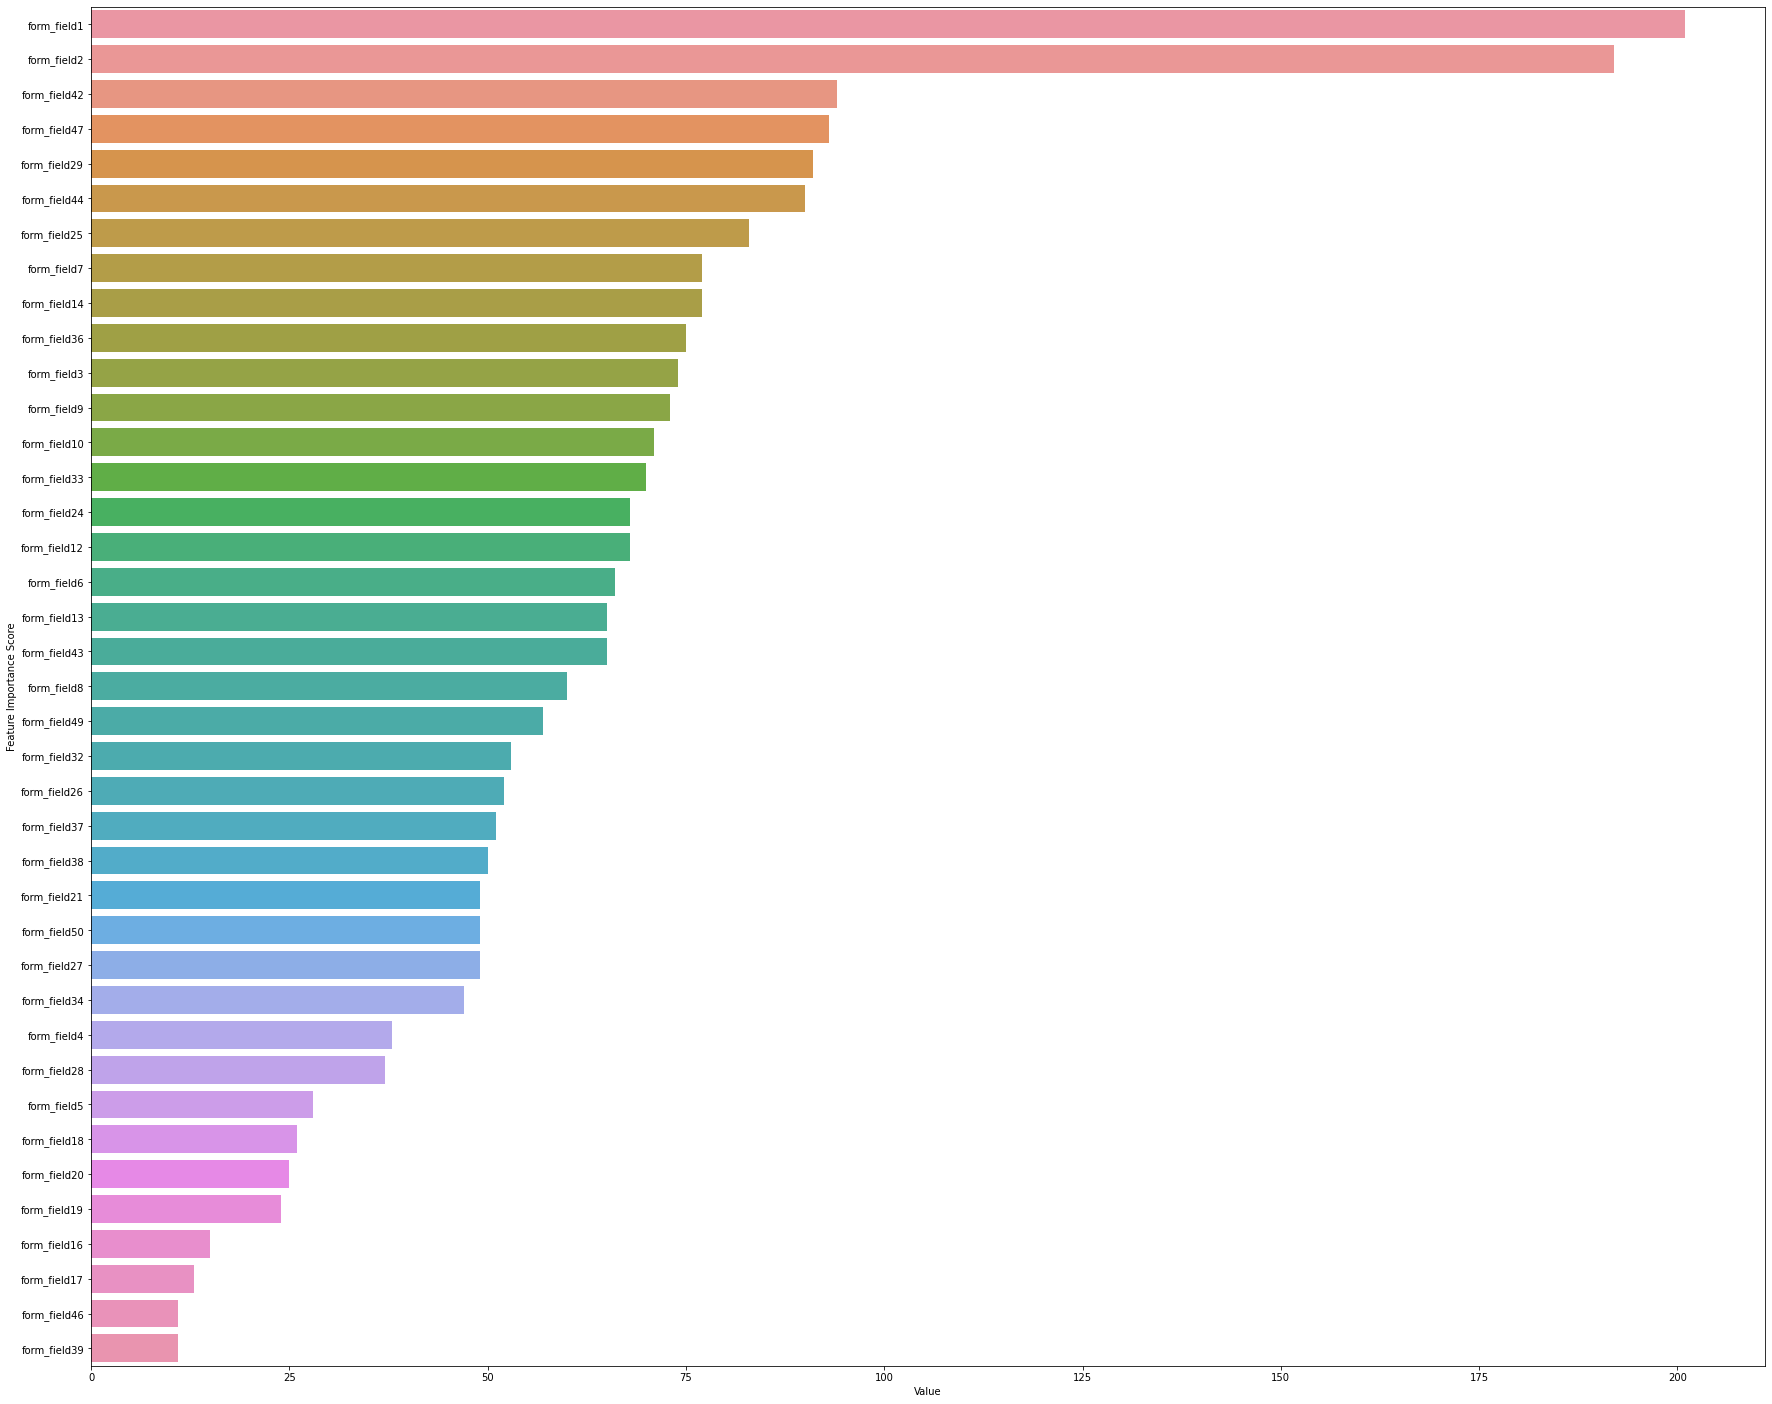

0.8365166822997825 0.8745688251746919 0.005821456823478337


In [ ]:
from sklearn.metrics import roc_auc_score,log_loss
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,  
                            #scale_pos_weight = 3.08,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test_df, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

#MODEL 2 - CATBOOST
The CATBOOST and XGBOOST models were trained on GPU(Google Colab) in order to save time. To train on CPU, you would have to remove the task_type and devices parameters.


================================Fold1====================================
0:	learn: 0.7872046	test: 0.7892086	best: 0.7892086 (0)	total: 90.4ms	remaining: 15m 4s
50:	learn: 0.8272213	test: 0.8234567	best: 0.8234567 (50)	total: 2.63s	remaining: 8m 34s
100:	learn: 0.8322191	test: 0.8279278	best: 0.8279278 (100)	total: 5.03s	remaining: 8m 12s
150:	learn: 0.8348267	test: 0.8299339	best: 0.8299339 (150)	total: 7.42s	remaining: 8m 4s
200:	learn: 0.8368419	test: 0.8314146	best: 0.8314146 (200)	total: 9.83s	remaining: 7m 59s
250:	learn: 0.8384062	test: 0.8323596	best: 0.8323596 (250)	total: 12.2s	remaining: 7m 55s
300:	learn: 0.8398470	test: 0.8332193	best: 0.8332193 (300)	total: 14.7s	remaining: 7m 54s
350:	learn: 0.8411679	test: 0.8341095	best: 0.8341095 (350)	total: 17.2s	remaining: 7m 53s
400:	learn: 0.8422424	test: 0.8346705	best: 0.8346705 (400)	total: 19.8s	remaining: 7m 53s
450:	learn: 0.8432738	test: 0.8351800	best: 0.8351800 (450)	total: 22.2s	remaining: 7m 50s
500:	learn: 0.8442994	

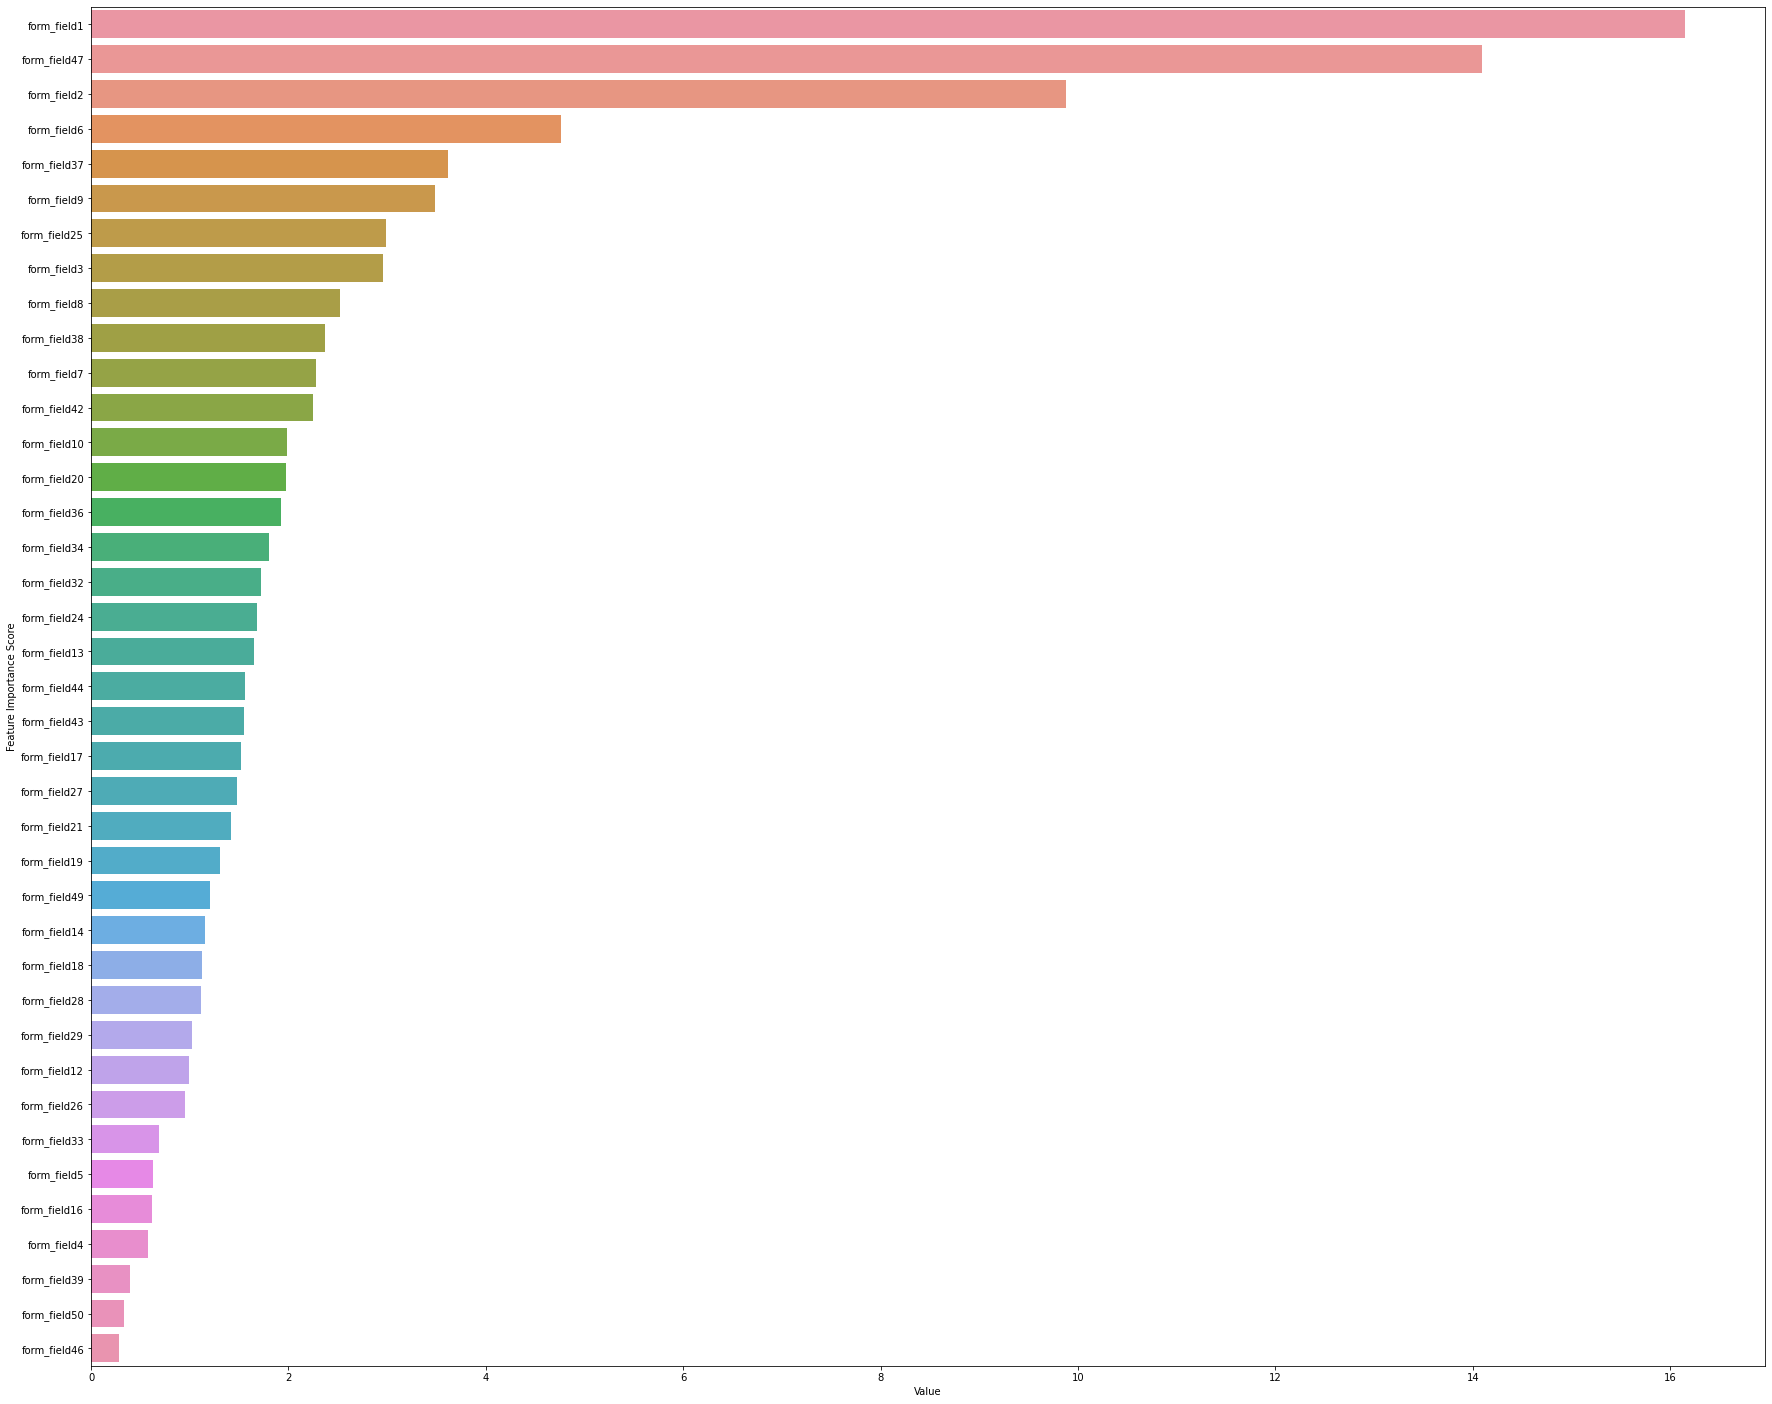

0.8385014780223999 0.8585697564583434 0.005935401822760205


In [ ]:
catboost = cat_.CatBoostClassifier(n_estimators=10000, max_depth=6, eval_metric='AUC', reg_lambda = 370,task_type="GPU",  devices='0:1')

func_= func(train, target, test_df, catboost, 'catboost', 1000) #scale_pos_weight = 3.08,
val_p1, test_p1, model1 = func_()

#MODEL 3 - XGBOOST
To train on CPU, you would have to remove the tree_method and gpu_id parameters.



================================Fold1====================================
[0]	validation_0-auc:0.732246
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.757299
[2]	validation_0-auc:0.774747
[3]	validation_0-auc:0.777431
[4]	validation_0-auc:0.790328
[5]	validation_0-auc:0.796385
[6]	validation_0-auc:0.797523
[7]	validation_0-auc:0.799214
[8]	validation_0-auc:0.800372
[9]	validation_0-auc:0.802863
[10]	validation_0-auc:0.803878
[11]	validation_0-auc:0.805774
[12]	validation_0-auc:0.80783
[13]	validation_0-auc:0.809927
[14]	validation_0-auc:0.812243
[15]	validation_0-auc:0.813139
[16]	validation_0-auc:0.814242
[17]	validation_0-auc:0.815466
[18]	validation_0-auc:0.816371
[19]	validation_0-auc:0.817332
[20]	validation_0-auc:0.818095
[21]	validation_0-auc:0.819452
[22]	validation_0-auc:0.82089
[23]	validation_0-auc:0.821391
[24]	validation_0-auc:0.821705
[25]	validation_0-auc:0.821933
[26]	validation_0-auc:0.822368
[27]	validation_0-auc:0.822649
[28]	v

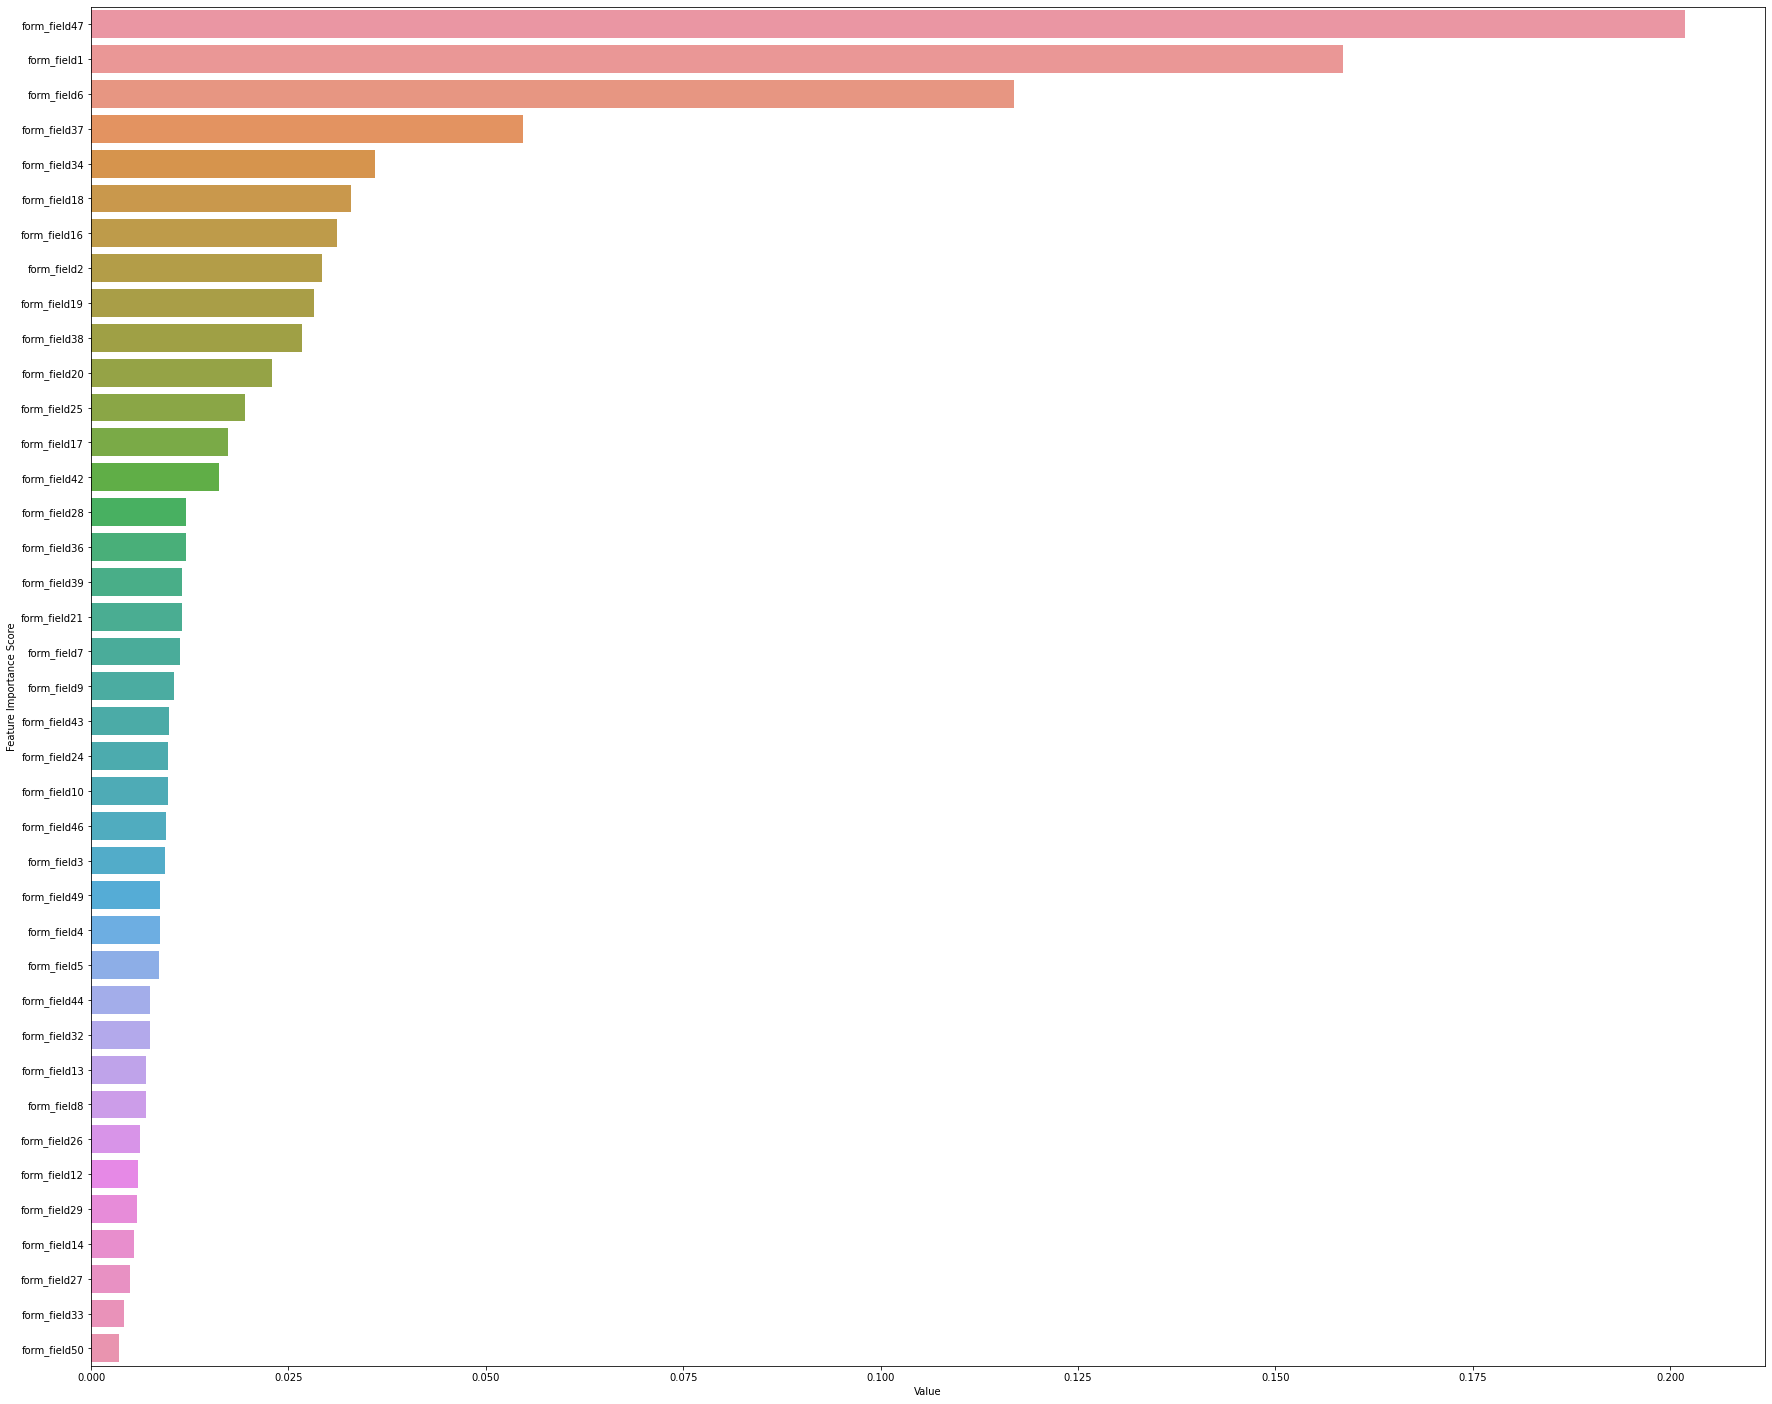

0.8370693268440276 0.8681195061819242 0.006116615897118054


In [ ]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          #scale_pos_weight = 3.08,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, tree_method='gpu_hist', gpu_id=0)

func_= func(train, target, test_df, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

#STACKING
To stack, we use a simple algorithm as a meta-learner(Linear Regression) to finetune our predictions. We train this algorithm with the predictions of validation sets from all algorithms and use to produce the final predictions with the combination of the test set predictions from all algorithms.



In [ ]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

#SUBMISSION


In [ ]:
sub['default_status'] = predict
sub.to_csv('solution_stack.csv',index=False)
sub.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.403809
1,Apcnt_1000048,0.323890
2,Apcnt_1000052,0.379284
3,Apcnt_1000076,0.766664
4,Apcnt_1000080,0.196948


In [ ]:
from google.colab import files
files.download('solution_stack.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1234)

In [ ]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]; categorical_features_indices

array([12, 36])

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss,f1_score
errcb=[]
y_pred_totcb=[]
fold=KFold(n_splits=5, shuffle=True, random_state=10)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostClassifier(metric_period=20)  #,scale_pos_weight = 3.08)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],verbose=100, early_stopping_rounds=100)
    preds=m.predict_proba(X_test)
    errcb.append(log_loss(y_test,preds)) 
    p = m.predict_proba(test_df)                   
    y_pred_totcb.append(p)

Learning rate set to 0.081054
0:	learn: 0.6427663	test: 0.6427663	test1: 0.6415805	best: 0.6415805 (0)	total: 27.7ms	remaining: 27.6s


100:	learn: 0.4007563	test: 0.4007563	test1: 0.4033715	best: 0.4033715 (100)	total: 2.42s	remaining: 21.5s
200:	learn: 0.3852983	test: 0.3852983	test1: 0.4011424	best: 0.4011319 (197)	total: 4.77s	remaining: 19s
300:	learn: 0.3724069	test: 0.3724069	test1: 0.4008194	best: 0.4008194 (300)	total: 7.07s	remaining: 16.4s
400:	learn: 0.3597136	test: 0.3597136	test1: 0.4011169	best: 0.4006922 (308)	total: 9.43s	remaining: 14.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4006921823
bestIteration = 308

Shrink model to first 309 iterations.
Learning rate set to 0.081054
0:	learn: 0.6442555	test: 0.6442555	test1: 0.6454529	best: 0.6454529 (0)	total: 28.1ms	remaining: 28.1s


100:	learn: 0.3976261	test: 0.3976261	test1: 0.4164374	best: 0.4164215 (99)	total: 2.44s	remaining: 21.8s
200:	learn: 0.3817344	test: 0.3817344	test1: 0.4155294	best: 0.4150988 (161)	total: 4.79s	remaining: 19.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4150988245
bestIteration = 161

Shrink model to first 162 iterations.
Learning rate set to 0.081054
0:	learn: 0.6421858	test: 0.6421858	test1: 0.6425853	best: 0.6425853 (0)	total: 28.8ms	remaining: 28.8s


100:	learn: 0.3987996	test: 0.3987996	test1: 0.4121080	best: 0.4121080 (100)	total: 2.38s	remaining: 21.2s
200:	learn: 0.3826330	test: 0.3826330	test1: 0.4101311	best: 0.4100277 (171)	total: 4.71s	remaining: 18.7s
300:	learn: 0.3688242	test: 0.3688242	test1: 0.4101429	best: 0.4097805 (284)	total: 7.03s	remaining: 16.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4097804509
bestIteration = 284

Shrink model to first 285 iterations.
Learning rate set to 0.081054
0:	learn: 0.6433151	test: 0.6433151	test1: 0.6438849	best: 0.6438849 (0)	total: 29.1ms	remaining: 29.1s


100:	learn: 0.3979960	test: 0.3979960	test1: 0.4144800	best: 0.4144800 (100)	total: 2.37s	remaining: 21.1s
200:	learn: 0.3830348	test: 0.3830348	test1: 0.4124268	best: 0.4123500 (193)	total: 4.68s	remaining: 18.6s
300:	learn: 0.3693514	test: 0.3693514	test1: 0.4122220	best: 0.4120748 (289)	total: 6.98s	remaining: 16.2s
400:	learn: 0.3564348	test: 0.3564348	test1: 0.4123960	best: 0.4120479 (340)	total: 9.34s	remaining: 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.412047914
bestIteration = 340

Shrink model to first 341 iterations.
Learning rate set to 0.081054
0:	learn: 0.6424764	test: 0.6424764	test1: 0.6423278	best: 0.6423278 (0)	total: 29.2ms	remaining: 29.2s


100:	learn: 0.3992497	test: 0.3992497	test1: 0.4101308	best: 0.4101014 (99)	total: 2.4s	remaining: 21.3s
200:	learn: 0.3835039	test: 0.3835039	test1: 0.4086234	best: 0.4082841 (166)	total: 4.75s	remaining: 18.9s
300:	learn: 0.3698648	test: 0.3698648	test1: 0.4084378	best: 0.4082394 (265)	total: 7.07s	remaining: 16.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.4082393539
bestIteration = 265

Shrink model to first 266 iterations.


In [ ]:
np.mean(errcb)

0.40917174509168464

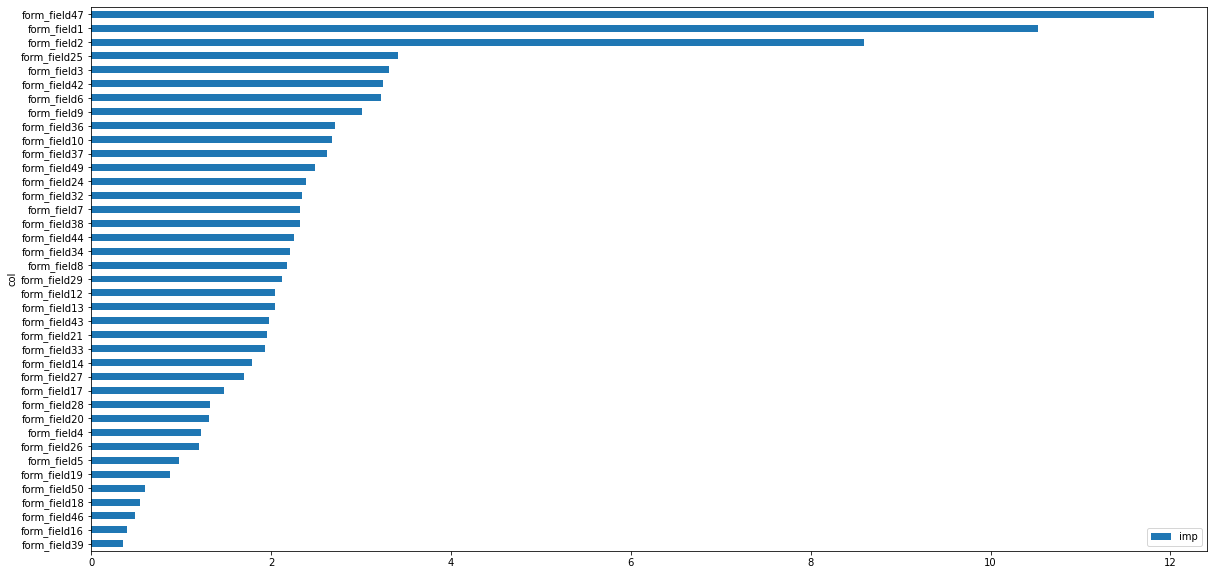

In [ ]:
from matplotlib import pyplot as plt
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-60:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png') 

In [ ]:
sub_id = sub['Applicant_ID']	

In [ ]:
sub['Applicant_ID'] = sub_id
sub['default_status'] = np.mean(y_pred_totcb, 0)
sub.to_csv("solution_cat.csv", index = False)
sub.head()

,Applicant_ID,default_status
0,Apcnt_1000032,0.613450
1,Apcnt_1000048,0.670144
2,Apcnt_1000052,0.644097
3,Apcnt_1000076,0.268317
4,Apcnt_1000080,0.788122


In [ ]:
from google.colab import files
files.download('solution_cat.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# FEATURES SELECTION:

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0)) # remember to set the seed, the random state in this function
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [ ]:
SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

SelectFromModel(estimator=Lasso(alpha=0.005, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=0,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [ ]:
feature_sel_model.get_support()

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False,  True, False,  True, False,  True,
        True, False,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False, False,
        True,  True, False])

In [ ]:
#Let's print the number of total and selected features:
#pip install Scrapy

In [ ]:
# This is how we can make a list of the selected features
selected_feat = X_train.columns[(feature_sel_model.get_support())]

In [ ]:
# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 39
selected features: 20


In [ ]:
#print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))
selected_feat

Index(['form_field1', 'form_field2', 'form_field3', 'form_field4',
       'form_field5', 'form_field16', 'form_field18', 'form_field20',
       'form_field21', 'form_field25', 'form_field32', 'form_field33',
       'form_field34', 'form_field36', 'form_field37', 'form_field38',
       'form_field42', 'form_field43', 'form_field47', 'form_field49'],
      dtype='object')